## Link to article

This notebook is included in the documentation, where the interactive Plotly charts show up. See:
https://pegasystems.github.io/pega-datascientist-tools/Python/articles/Example_ADM_Analysis.html

# Example ADM analysis
See this notebook for an introduction to the ADMDatamart class to get an overview of the currently implemented features in the Python version of CDH Tools. If you have any suggestions for new features, please do not hesitate to raise an issue in Git, or even better: create a pull request yourself!

This notebook builds upon the [Getting Started guide](https://github.com/pegasystems/pega-datascientist-tools/wiki#using-the-python-tools). 

## Reading the data
Reading the data is quite simple. All you need to do is to give a directory location to the ADMSnapshot class and it will automatically detect the latest files and import them. There is also a default function to import the CDH Sample data directly from the internet, as you can see below:

In [1]:
# These lines are only for rendering in the docs, and are hidden through Jupyter tags
# Do not run if you're running the notebook seperately

import plotly.io as pio
pio.renderers.default='notebook_connected'

import sys
sys.path.append('../../../')

In [2]:
from pdstools import ADMDatamart, datasets

CDHSample = datasets.CDHSample()

## Visualisations
The following visualisations are currently available in the python version of CDH Tools. See the table below for which visualisations are applicable to what types of data:

In [3]:
CDHSample.AvailableVisualisations

modelData  predictorData  \
plotPerformanceSuccessRateBubbleChart          1              0   
plotPerformanceAndSuccessRateOverTime          1              0   
plotOverTime                                   1              0   
plotResponseCountMatrix                        1              0   
plotPropositionSuccessRates                    1              0   
plotScoreDistribution                          1              1   
plotPredictorBinning                           1              1   
plotPredictorPerformance                       1              1   
plotPredictorPerformanceHeatmap                1              1   
plotImpactInfluence                            1              1   
plotResponseGain                               1              0   
plotModelsByPositives                          1              0   
plotTreeMap                                    1              0   

                                       Multiple snapshots  
plotPerformanceSuccessRateBubbleChart                   0  
plotPerformanceAndSuccessRateOverTime                   1  
plotOverTime                                            1  
plotResponseCountMatrix                                 1  
plotPropositionSuccessRates                             0  
plotScoreDistribution                                   0  
plotPredictorBinning                                    0  
plotPredictorPerformance                                0  
plotPredictorPerformanceHeatmap                         0  
plotImpactInfluence                                     0  
plotResponseGain                                        0  
plotModelsByPositives                                   0  
plotTreeMap                                             0

As you can see, every visualisation needs modelData, a few also need predictorData, and plotPerformanceAndSuccessRateOverTime, plotOverTime and plotResponseCountMatrix are the only visualisations requiring multiple snapshots.

Let's quickly go over some easy ones to see what it does below. To start out with the bubble chart, which we can simply call by calling plotPerformanceSuccessRateBubbleChart with our main class.

In [4]:
CDHSample.plotPerformanceSuccessRateBubbleChart()

Looks like a healthy bubble plot, but sometimes it is useful to consider only certain models in the analysis. Note that the bubble chart automatically considers only the last snapshot by default, though this is a parameter. 

To reduce the information, let's only consider models with more than 500 responses within the CreditCards group. 

In [5]:
query='ResponseCount > 500 and Group == "CreditCards"'
CDHSample.plotPerformanceSuccessRateBubbleChart(query=query)

Alternatively, we could only look at the top n best performing models within our query. To do this, we need to supply a list of model IDs which we can easily extract from the data as such.

Note here the alternative querying syntax you can use, which was default in the previous version of CDH Tools: if you have a list (list) to subset a column's values with, you can simply supply a dictionary with 'column name':list to only get values in that list for that column.

In [6]:
top30ids = list(CDHSample.last(CDHSample.modelData).sort_values('Performance', ascending=False).reset_index()['ModelID'][0:30])

CDHSample.plotPerformanceSuccessRateBubbleChart(query={'ModelID':top30ids})

The bubble chart gives some information about which models perform well, but that is not always informative: if we don't know in which channels, issues or groups our issues lie then we may not be looking in the right place. This is where the Treemap visualisation is quite handy. 

In [7]:
CDHSample.plotTreeMap()

By default the Treemap shows the weighted performance, where the performance is weighted by the response count. The squares represent Model IDs: the larger a square, the more model IDs are within that combination of context keys. We can also color the Treemap by another variable, such as the SuccessRate:

In [8]:
CDHSample.plotTreeMap('SuccessRate')

If we want to look at the response rate and the AUC of some models over time, we can call plotPerformanceAndSuccessRateOverTime. Here, we filter a bit to limit the amount of information.

Plot is only available in matplotlib.
Maximum AUC across all models: 0.77


<AxesSubplot: xlabel='Date', ylabel='ResponseCount'>

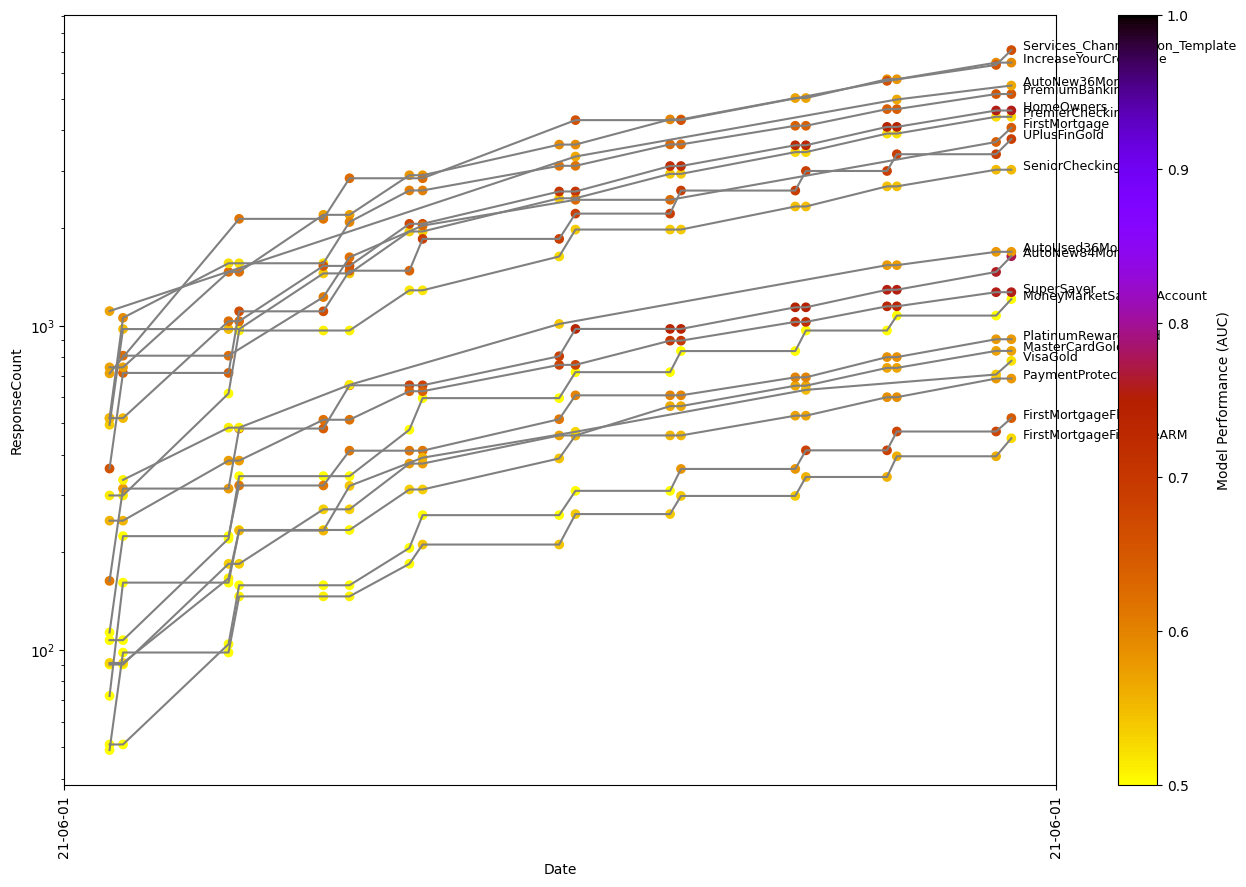

In [9]:
CDHSample.plotPerformanceAndSuccessRateOverTime(query = "Channel == 'Web'")

Similar to the responses, the success rate over time can also be of interest. With 'plotSuccessRateOverTime', you can plot the success rate of different models as they develop over time.

In [10]:
CDHSample.plotOverTime('SuccessRate',by='ModelID', query="Channel=='Web'")

And if it is not interesting to consider the success rate over time, there is also 'plotPropositionSuccessRates', which by default considers the last state of the models and plots the histogram of their success rates.

In [11]:
CDHSample.plotPropositionSuccessRates(query="Channel=='Web'")

If we want to look at the distribution of responses and their propensities for a given model, we can subset that model and call plotScoreDistribution. Note here we subset the model by its ID.

In [12]:
CDHSample.plotScoreDistribution(query='ModelID == "08ca1302-9fc0-57bf-9031-d4179d400493"', show_each=False)

Alternatively, we can also subset a model by its model name, and then further drill down by group/issue/channel/configuration. See the example below.

In [13]:
CDHSample.plotScoreDistribution(query='ModelName == "HomeOwners" and Group == "Bundles" and Issue == "Sales" and Channel == "Web" and Configuration == "OmniAdaptiveModel"')

Similarly, we can also display the distribution of a single predictor and its binning. This function loops through each predictor of a model and generates the binning image for that predictor. For that reason we recommend subsetting the predictor names ahead of time or, depending on how many predictors the model has, a lot of images will be generated.

In [14]:
CDHSample.plotPredictorBinning(query=f'ModelID == "08ca1302-9fc0-57bf-9031-d4179d400493" and PredictorName in {["Customer.Age", "Customer.AnnualIncome", "IH.Email.Outbound.Accepted.pxLastGroupID"]}', show_each=True);

Alternatively we can look at the performance of a predictor over multiple models. Again, we recommend subsetting the predictor names with a list to make it more legible. 

In [15]:
CDHSample.plotPredictorPerformance(query=f'PredictorName in {["Customer.Age", "Customer.AnnualIncome", "IH.Email.Outbound.Accepted.pxLastGroupID"]}')

What the two previous visualisations could not represent very well is the performance of the predictors over different models. That is what the plotPredictorPerformanceHeatmap function does; again with subsetting of predictors as a recommended step.

In [16]:
CDHSample.plotPredictorPerformanceHeatmap(query=f'PredictorName in {["Customer.Age", "Customer.AnnualIncome", "IH.Email.Outbound.Accepted.pxLastGroupID"]}')